In [7]:
# Imports
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 

In [8]:
# Read in saved data
data = pd.read_csv('../saved_data/chicago_food_venues_details_cleaned.csv')
data

,Unnamed: 0,id,name,latitude,longitude,primary_category,popularity_rating,verified,tip_count,price_tier,...,live music,jukebox,bar service,bar snacks,tasting menu,valet parking,byo,parking,table service,price
0,0,49e749fbf964a52086641fe3,The Gage,41.881202,-87.624481,Gastropub,2.0,1,336,3,...,0,0,0,0,0,0,0,0,0,3
1,1,55669b9b498ee34e5249ea61,Cindy's,41.881695,-87.624600,New American Restaurant,23.0,1,137,3,...,0,0,0,0,0,0,0,0,0,3
2,2,556b5527498e3bb54be5ff78,Cherry Circle Room,41.881994,-87.625050,American Restaurant,NaN,1,42,3,...,0,0,0,0,0,0,0,0,0,3
3,3,53d6f406498e54a8e8dfb7c4,Acanto,41.881495,-87.624500,Italian Restaurant,NaN,0,22,4,...,0,0,0,0,0,0,0,0,0,4
4,4,4ac7958cf964a52036b820e3,Terzo Piano,41.880443,-87.622431,Italian Restaurant,NaN,1,51,3,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,4c6b0b116d390f4708ed099a,The Florentine,41.879170,-87.633032,Italian Restaurant,NaN,1,51,3,...,0,0,0,0,0,0,0,0,0,3
196,196,5755b556498ea375c5d4baac,The Dearborn,41.884415,-87.629554,Gastropub,3.0,0,47,3,...,0,0,0,0,0,0,0,0,0,3
197,197,4ad91beff964a5202e1821e3,Shaw's Crab House,41.889959,-87.627065,Seafood Restaurant,4.0,1,209,3,...,1,0,0,0,0,0,0,0,0,3
198,198,59deb72f061b514b32a062af,Gibson Italia,41.886606,-87.639593,Italian Restaurant,5.0,0,19,4,...,0,0,0,0,0,0,0,0,0,4


### Diagnostics

In [30]:
# Analysis of where top 25 restaurants are located
top_25 = data.loc[data.popularity_rating <= 25]
not_top_25 = data.loc[data.popularity_rating.isnull()]
top_25

m = folium.Map(location=[41.8781, -87.6298], zoom_start=12)

# add not top 25
for lat, lng, name, pc in zip(not_top_25['latitude'], not_top_25['longitude'], not_top_25['name'], not_top_25['primary_category']):
    label = '{}, {}'.format(name, pc)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(m) 
    
# add top 25
for lat, lng, name, pc in zip(top_25['latitude'], top_25['longitude'], top_25['name'], top_25['primary_category']):
    label = '{}, {}'.format(name, pc)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(m) 
    
m

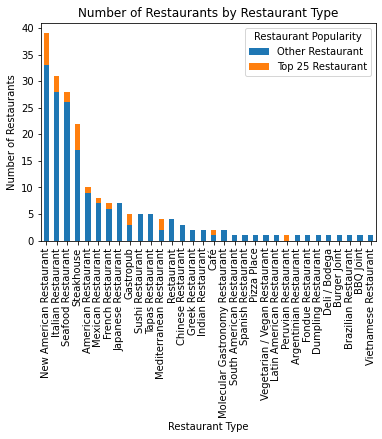

In [9]:
# Find distribution of restaurant type by top 25 v not top 25
data.loc[data['popularity_rating'] <= 25, 'Restaurant Popularity'] = 'Top 25 Restaurant'
data.loc[data['popularity_rating'].isnull(), 'Restaurant Popularity'] = 'Other Restaurant'
cat_dist = data[['Restaurant Popularity','primary_category']].groupby(['Restaurant Popularity','primary_category']).size().reset_index(name="num_rests")
cat_dist2 = cat_dist.pivot(index="primary_category", columns="Restaurant Popularity", values="num_rests")
cat_dist2.loc[cat_dist2['Other Restaurant'].isnull(),'Other Restaurant'] = 0
cat_dist2.loc[cat_dist2['Top 25 Restaurant'].isnull(),'Top 25 Restaurant'] = 0
cat_dist2['Total Restaurants'] = cat_dist2['Other Restaurant'] + cat_dist2['Top 25 Restaurant']
cat_dist2.sort_values(by=['Total Restaurants'], ascending = False, inplace=True)
cat_dist2.drop(columns=['Total Restaurants'], inplace=True)
ax = cat_dist2.plot.bar(title='Number of Restaurants by Restaurant Type',stacked=True)
ax.set(ylabel='Number of Restaurants',xlabel='Restaurant Type')
ax

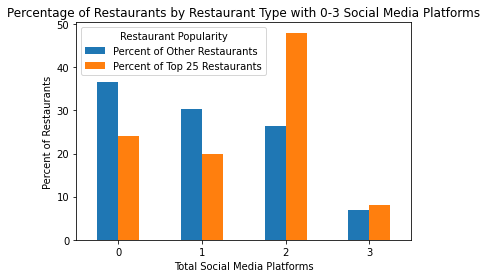

In [24]:
# Number of social media platforms
data['Total Social Media'] = data['twitter_available'] + data['instagram_available'] + data['facebook_available']
data.sort_values(by=['Total Social Media', 'Restaurant Popularity','name'], ascending=False, inplace=True)
social_media = data[['name','Total Social Media', 'Restaurant Popularity']]
social_media = social_media.groupby(['Total Social Media', 'Restaurant Popularity']).size().reset_index(name="num_rests")
social_media2 = social_media.pivot(index="Total Social Media", columns="Restaurant Popularity", values="num_rests")
social_media2['Percent of Other Restaurants'] = social_media2['Other Restaurant']/175*100
social_media2['Percent of Top 25 Restaurants'] = social_media2['Top 25 Restaurant']/25*100
social_media2.drop(columns=['Other Restaurant','Top 25 Restaurant'], inplace=True)
ax2 = social_media2.plot.bar(title='Percentage of Restaurants by Restaurant Type with 0-3 Social Media Platforms',rot=0)
ax2.set(ylabel='Percent of Restaurants',xlabel='Total Social Media Platforms')
ax2 

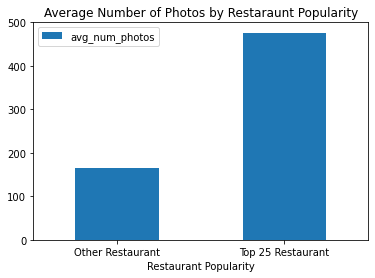

In [18]:
# Photos
photos = data.groupby(['Restaurant Popularity'])['photos_count'].agg('mean').reset_index(name='avg_num_photos')
ax3 = photos.plot.bar(x='Restaurant Popularity', y='avg_num_photos', title='Average Number of Photos by Restaraunt Popularity',rot=0)
ax3

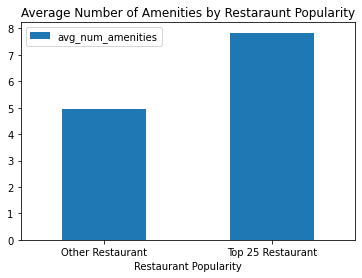

In [18]:
# Number of amenities
amenities = data.drop(data.iloc[:, 0:21], axis = 1)
amenities.drop(columns=['price'], inplace = True)
amenities.loc[:,'Row_Total'] = amenities.sum(numeric_only=True, axis=1)
amenities2 = amenities.groupby(['Restaurant Popularity'])['Row_Total'].agg('mean').reset_index(name='avg_num_amenities')
ax4 = amenities2.plot.bar(x='Restaurant Popularity', y='avg_num_amenities', title='Average Number of Amenities by Restaraunt Popularity',rot=0)
ax4

### Logistic Regression Analysis

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)
y = np.asarray(churn_df['churn'])
y [0:5]
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR
yhat = LR.predict(X_test)
yhat

In [ ]:
X = np.asarray(data[['latitude', 'longitude', 'verified', 'tip_count','price_tier','likes','rating','delivery_available','menu_available','specials_count','']])
X[0:5]
